## Import Modules

In [1]:
#import modules
from statsbombpy import sb

import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import math
import time
import warnings
warnings.filterwarnings('ignore')

## Define specialized variables

In [2]:
match_week_stage = math.floor((3/4)*38)
print(match_week_stage)

28


## Obtain League and shots data from Statsbomb

In [3]:
competitions = sb.competitions()

In [4]:
competitions

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
1,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-02-14T05:41:27.566989,None,None,2024-02-14T05:41:27.566989
2,16,4,Europe,Champions League,male,False,False,2018/2019,2023-03-07T12:20:48.118250,2021-06-13T16:17:31.694,None,2023-03-07T12:20:48.118250
3,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
4,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
...,...,...,...,...,...,...,...,...,...,...,...,...
66,55,43,Europe,UEFA Euro,male,False,True,2020,2023-02-24T21:26:47.128979,2023-04-27T22:38:34.970148,2023-04-27T22:38:34.970148,2023-02-24T21:26:47.128979
67,35,75,Europe,UEFA Europa League,male,False,False,1988/1989,2023-06-18T19:28:39.443883,2021-06-13T16:17:31.694,None,2023-06-18T19:28:39.443883
68,53,106,Europe,UEFA Women's Euro,female,False,True,2022,2023-10-24T03:36:54.066267,2023-10-24T03:37:29.085948,2023-10-24T03:37:29.085948,2023-10-24T03:36:54.066267
69,72,107,International,Women's World Cup,female,False,True,2023,2023-12-12T14:06:50.626363,2023-12-12T14:12:41.561162,2023-12-12T14:12:41.561162,2023-12-12T14:06:50.626363


In [5]:
pd.unique(competitions['competition_name'])

array(['1. Bundesliga', 'African Cup of Nations', 'Champions League',
       'Copa del Rey', "FA Women's Super League", 'FIFA U20 World Cup',
       'FIFA World Cup', 'Indian Super league', 'La Liga',
       'Liga Profesional', 'Ligue 1', 'Major League Soccer',
       'North American League', 'NWSL', 'Premier League', 'Serie A',
       'UEFA Euro', 'UEFA Europa League', "UEFA Women's Euro",
       "Women's World Cup"], dtype=object)

In [6]:
competitions[
    (competitions['competition_name'].isin([
    'Premier League', '1. Bundesliga', 'La Liga', 'Ligue 1', 'Serie A']))
             & 
    (competitions['season_name']=='2015/2016')
            ]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
41,11,27,Spain,La Liga,male,False,False,2015/2016,2023-09-20T17:21:32.111535,2021-06-13T16:17:31.694,None,2023-09-20T17:21:32.111535
58,7,27,France,Ligue 1,male,False,False,2015/2016,2023-12-13T00:27:57.162379,None,None,2023-12-13T00:27:57.162379
62,2,27,England,Premier League,male,False,False,2015/2016,2023-11-14T11:25:33.476498,2021-06-13T16:17:31.694,None,2023-11-14T11:25:33.476498
64,12,27,Italy,Serie A,male,False,False,2015/2016,2023-12-13T17:32:46.423081,None,None,2023-12-13T17:32:46.423081


In [7]:
#competitions[competitions['competition_name']=='Champions League']

In [8]:
Ligue1 = sb.matches(competition_id=7, season_id=27)
Ligue1.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3901199,2016-04-02,20:00:00.000,France - Ligue 1,2015/2016,Rennes,Stade de Reims,3,1,available,...,None,32,Regular Season,Roazhon Park,Saïd Ennjimi,Rolland Courbis,Olivier Guégan,1.1.0,2,2
1,3901178,2016-03-12,18:00:00.000,France - Ligue 1,2015/2016,Lorient,Marseille,1,1,available,...,None,30,Regular Season,Stade Yves Allainmat - Le Moustoir,Ruddy Buquet,Sylvain Ripoll,José Miguel González Martín del Campo,1.1.0,2,2
2,3901260,2016-05-14,21:00:00.000,France - Ligue 1,2015/2016,Lorient,Gazélec Ajaccio,1,0,available,...,None,38,Regular Season,Stade Yves Allainmat - Le Moustoir,Benoît Millot,Sylvain Ripoll,Thierry Laurey,1.1.0,2,2
3,3829470,2015-09-20,17:00:00.000,France - Ligue 1,2015/2016,Saint-Étienne,Nantes,2,0,available,...,None,6,Regular Season,Stade Geoffroy-Guichard,Benoît Millot,Christophe Galtier,Michel Der Zakarian,1.1.0,2,2
4,3901259,2016-05-14,21:00:00.000,France - Ligue 1,2015/2016,Troyes,Marseille,1,1,available,...,None,38,Regular Season,Stade de l''Aube,François Letexier,Mohamed Bradja,Franck Passi,1.1.0,2,2


In [9]:
Ligue1.columns

Index(['match_id', 'match_date', 'kick_off', 'competition', 'season',
       'home_team', 'away_team', 'home_score', 'away_score', 'match_status',
       'match_status_360', 'last_updated', 'last_updated_360', 'match_week',
       'competition_stage', 'stadium', 'referee', 'home_managers',
       'away_managers', 'data_version', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object')

In [10]:
print(pd.unique(Ligue1['home_team']))

['Rennes' 'Lorient' 'Saint-Étienne' 'Troyes' 'Nantes' 'Bastia' 'Guingamp'
 'Paris Saint-Germain' 'Marseille' 'Lille' 'Gazélec Ajaccio' 'Caen'
 'AS Monaco' 'Angers' 'Stade de Reims' 'Bordeaux' 'Lyon' 'OGC Nice'
 'Montpellier' 'Toulouse']


In [11]:
Ligue1.iloc[0]

match_id                                    3901199
match_date                               2016-04-02
kick_off                               20:00:00.000
competition                        France - Ligue 1
season                                    2015/2016
home_team                                    Rennes
away_team                            Stade de Reims
home_score                                        3
away_score                                        1
match_status                              available
match_status_360                        unscheduled
last_updated             2023-11-14T11:49:10.184615
last_updated_360                               None
match_week                                       32
competition_stage                    Regular Season
stadium                                Roazhon Park
referee                                Saïd Ennjimi
home_managers                       Rolland Courbis
away_managers                        Olivier Guégan
data_version

In [12]:
example = sb.events(match_id=3754037)
example.columns

Index(['ball_receipt_outcome', 'ball_recovery_offensive',
       'ball_recovery_recovery_failure', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_right_foot', 'counterpress',
       'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_technique', 'goalkeeper_type', 'id',
       'index', 'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_end_location', 'pass_goal_assist', 'pass_height',
   

In [13]:
relevant_attributes = ['minute', 'second', 'team', 'shot_statsbomb_xg',
                       'player', 'position', 'location', 'shot_body_part',
       'shot_end_location', 'shot_first_time', 
         'shot_technique',
       'shot_type', 'type','shot_outcome', 'under_pressure']

## Obtain dataframe of all shots up to our matchweek stage

In [14]:
Ligue1_shots_df = pd.DataFrame(columns=relevant_attributes)

In [15]:
start = time.time()
for match in Ligue1[Ligue1['match_week']<=match_week_stage]['match_id']:
    match_df = sb.events(match_id=match)
    relevant_match_df = match_df[relevant_attributes][match_df['type']=='Shot']
    Ligue1_shots_df = pd.concat([Ligue1_shots_df, relevant_match_df], ignore_index=True)

Ligue1_shots_df['shot_outcome'] = Ligue1_shots_df['shot_outcome'].replace(
    to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
               'Saved to Post': 0, 'Saved Off Target': 0})

Ligue1_shots_df['distance'] = Ligue1_shots_df.apply(lambda row: np.sqrt(np.abs(
    row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
Ligue1_shots_df['shot_angle'] = Ligue1_shots_df.apply(
    lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
end = time.time()
print(f'script run time: {(end - start)/60} minutes')
Ligue1_shots_df

script run time: 4.859650186697642 minutes


,minute,second,team,shot_statsbomb_xg,player,position,location,shot_body_part,shot_end_location,shot_first_time,shot_technique,shot_type,type,shot_outcome,under_pressure,distance,shot_angle
0,14,38,Nantes,0.034955,Yacine Bammou,Left Center Forward,"[90.2, 31.1]",Left Foot,"[120.0, 48.3, 0.1]",NaN,Normal,Open Play,Shot,0,NaN,31.100643,0.290225
1,25,2,Saint-Étienne,0.138583,Jonathan Bamba,Left Wing,"[115.3, 51.0]",Left Foot,"[120.0, 36.4, 2.1]",NaN,Normal,Open Play,Shot,1,True,11.962023,1.167002
2,26,54,Saint-Étienne,0.076472,Jonathan Bamba,Left Wing,"[102.8, 45.2]",Right Foot,"[105.4, 44.5]",NaN,Normal,Open Play,Shot,0,NaN,17.968862,0.293589
3,28,26,Saint-Étienne,0.071937,Robert Berič,Center Forward,"[113.1, 44.3]",Right Foot,"[113.7, 44.0]",True,Backheel,Open Play,Shot,0,True,8.130191,0.557296
4,30,56,Saint-Étienne,0.039820,Robert Berič,Center Forward,"[103.5, 56.1]",Right Foot,"[120.0, 44.7, 1.7]",True,Normal,Open Play,Shot,0,True,23.053416,0.773129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6500,86,27,Marseille,0.023326,Bouna Sarr,Center Attacking Midfield,"[94.8, 29.0]",Right Foot,"[100.3, 31.4]",NaN,Normal,Open Play,Shot,0,NaN,27.496182,0.411577
6501,86,30,Marseille,0.041235,Georges-Kévin Nkoudou Mbida,Right Wing,"[106.6, 55.5]",Right Foot,"[120.0, 34.6, 0.8]",NaN,Normal,Open Play,Shot,0,NaN,20.489265,0.857935
6502,87,53,Marseille,0.069342,Abdelaziz Barrada,Left Defensive Midfield,"[99.0, 39.5]",Right Foot,"[119.0, 43.0, 0.2]",NaN,Normal,Open Play,Shot,0,NaN,21.005952,0.023805
6503,88,44,Caen,0.289594,Andy Delort,Center Forward,"[108.5, 29.3]",Right Foot,"[120.0, 35.2, 0.2]",NaN,Normal,Open Play,Shot,0,NaN,15.707960,0.749378


## Describing the Data

In [16]:
Ligue1_shots_df.describe()

,shot_statsbomb_xg,shot_outcome,distance,shot_angle
count,6505.000000,6505.000000,6505.000000,6505.000000
mean,0.097226,0.100692,19.818663,0.478457
std,0.137978,0.300943,9.114774,0.323582
min,0.000180,0.000000,1.702939,0.000000
25%,0.025296,0.000000,12.238055,0.211451
50%,0.050299,0.000000,19.016835,0.439843
75%,0.102174,0.000000,26.533941,0.703110
max,0.976663,1.000000,76.752199,1.560619


In [17]:
Ligue1_shots_df = Ligue1_shots_df[Ligue1_shots_df.shot_type != 'Corner']

In [18]:
Ligue1_shots_df['shot_outcome'].value_counts()

shot_outcome
0    5849
1     655
Name: count, dtype: int64

In [19]:
Ligue1_team_summary_df = pd.DataFrame(columns = ['team', 'shots', 'goals', 'statsbomb_xg', 'xg_overperformance'])
for team in pd.unique(Ligue1_shots_df['team']):
    shot_sum = Ligue1_shots_df['team'].value_counts()[team]
    goal_sum = sum(Ligue1_shots_df[Ligue1_shots_df['team']==team]['shot_outcome'])
    statsbomb_xg_sum = sum(Ligue1_shots_df[Ligue1_shots_df['team']==team]['shot_statsbomb_xg'])
    xg_overperformance = goal_sum - statsbomb_xg_sum
    new_row = pd.Series({'team': team, 'shots': shot_sum, 'goals': goal_sum, 'statsbomb_xg': statsbomb_xg_sum, 'xg_overperformance': xg_overperformance})
    Ligue1_team_summary_df.loc[len(Ligue1_team_summary_df)]=new_row
Ligue1_team_summary_df = Ligue1_team_summary_df.sort_values(by=['goals'], ascending=False)
totals_row = pd.Series({'team': 'Totals',
                        'shots': sum(Ligue1_team_summary_df['shots']),
                        'goals': sum(Ligue1_team_summary_df['goals']),
                        'statsbomb_xg': sum(Ligue1_team_summary_df['statsbomb_xg']),
                        'xg_overperformance': sum(Ligue1_team_summary_df['xg_overperformance'])})
Ligue1_team_summary_df.loc[len(Ligue1_team_summary_df)]=totals_row

Ligue1_team_summary_df

,team,shots,goals,statsbomb_xg,xg_overperformance
7,Paris Saint-Germain,387,66,49.400611,16.599389
3,Lyon,424,40,39.403791,0.596209
17,Lorient,323,39,31.708574,7.291426
5,AS Monaco,309,39,39.375797,-0.375797
11,Marseille,361,38,37.698828,0.301172
19,OGC Nice,299,36,31.686068,4.313932
2,Bordeaux,326,36,31.546215,4.453785
9,Montpellier,287,34,31.196897,2.803103
14,Rennes,312,33,34.483781,-1.483781
6,Guingamp,311,33,30.92845,2.07155


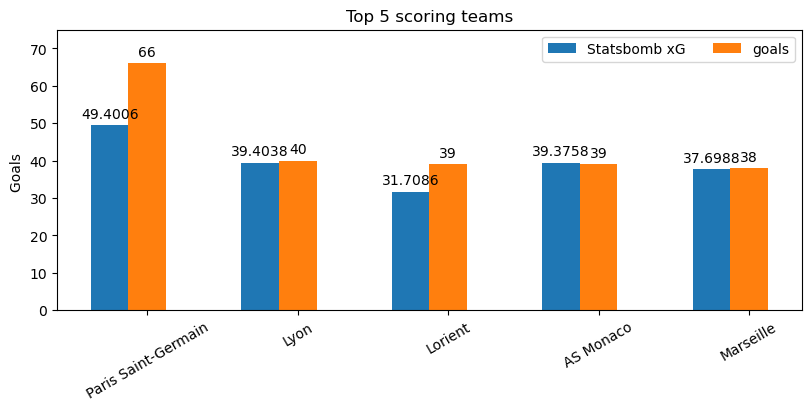

In [20]:
teams = Ligue1_team_summary_df['team'][0:5]
team_goals = {
    'Statsbomb xG': Ligue1_team_summary_df['statsbomb_xg'][0:5].round(),
    'goals': Ligue1_team_summary_df['goals'][0:5].round(),
}

x = np.arange(len(teams))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8,4))

for attribute, measurement in team_goals.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Goals ')
ax.set_title('Top 5 scoring teams')
ax.set_xticks(x + width, teams)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 75)
ax.tick_params(axis='x', rotation=30)
plt.show()

In [21]:
Ligue1_shots_df.columns

Index(['minute', 'second', 'team', 'shot_statsbomb_xg', 'player', 'position',
       'location', 'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_technique', 'shot_type', 'type', 'shot_outcome', 'under_pressure',
       'distance', 'shot_angle'],
      dtype='object')

## Split training and test data, train model and define functions

In [22]:
cap_x_df, y_df = pd.concat([Ligue1_shots_df.iloc[:,:-4], Ligue1_shots_df.iloc[:,-3:]], axis=1),Ligue1_shots_df.iloc[:,-4].to_frame()

In [23]:
train_cap_x_df, test_cap_x_df, train_y_df, test_y_df = \
train_test_split(cap_x_df, y_df,
                 test_size=0.20,
                random_state=42,
                 shuffle=True,
                stratify=y_df)

In [24]:
target_attr = 'shot_outcome'

In [25]:
numerical_attrs = ['distance', 'minute', 'shot_angle']

In [26]:
nominal_attrs = ['shot_technique', 'shot_type', 'shot_body_part', 'position', 'shot_first_time', 'under_pressure']

In [62]:
for attr in nominal_attrs:
    print(attr)
    print(pd.unique(cap_x_df[attr]))
    print(cap_x_df[attr].value_counts())

shot_technique
['Normal' 'Backheel' 'Half Volley' 'Volley' 'Overhead Kick' 'Lob'
 'Diving Header']
shot_technique
Normal           4964
Half Volley       968
Volley            416
Lob                55
Overhead Kick      45
Backheel           31
Diving Header      25
Name: count, dtype: int64
shot_type
['Open Play' 'Free Kick' 'Penalty']
shot_type
Open Play    6098
Free Kick     340
Penalty        66
Name: count, dtype: int64
shot_body_part
['Left Foot' 'Right Foot' 'Head' 'Other']
shot_body_part
Right Foot    3269
Left Foot     2035
Head          1178
Other           22
Name: count, dtype: int64
position
['Left Center Forward' 'Left Wing' 'Center Forward'
 'Right Defensive Midfield' 'Right Wing' 'Left Defensive Midfield'
 'Right Midfield' 'Left Back' 'Left Center Back'
 'Center Attacking Midfield' 'Right Center Forward' 'Left Midfield'
 'Right Center Back' 'Right Back' 'Left Center Midfield'
 'Center Defensive Midfield' 'Right Attacking Midfield'
 'Right Center Midfield' 'Right Wing B

In [27]:
numerical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer()),
               ("scaler", StandardScaler())]
    )

In [28]:
nominal_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="constant", fill_value=False)),
               ('target_encoder', TargetEncoder(target_type='auto', random_state=42)),
               #("target_encoder", OrdinalEncoder()),
               ("scaler", StandardScaler())
               ]
    )

In [29]:
preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, numerical_attrs),
            ('nominal', nominal_transformer, nominal_attrs)
        ]
    )

### The function below will be used to compare our models to the statsbomb model

In [47]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.figure()
    df = pd.DataFrame({'model1':model1,'model2':model2,'outcome':outcome})
    no_goal = df[df['outcome']==0]
    plt.scatter(no_goal['model1'],no_goal['model2'], label='no goal', color='blue', alpha=0.6, edgecolors='none')
    goal = df[df['outcome']==1]
    plt.scatter(goal['model1'],goal['model2'], label='goal', color='orange', alpha=0.9, edgecolors='none')
    #plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    plt.legend()
    plt.title("Comparison of " + model1_name + " to " + model2_name)
    z = np.polyfit(model1, model2,1)
    #z = np.polyfit(df['model1'], df['model2'],1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    #plt.plot(df['model1'], p(df['model1']),"r--")
    print(model1_name)
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

LogisticRegression
y=1.10x+-0.01
$R^2$= 0.1964626595104354
SGDClassifier
y=0.70x+0.01
$R^2$= 0.24019264421568465
RandomForestClassifier
y=0.69x+0.02
$R^2$= 0.44941937160178425
GradientBoostingClassifier
y=0.92x+0.01
$R^2$= 0.48722958697711105
DecisionTreeClassifier
y=0.14x+0.08
$R^2$= 0.11075782873089512


,shots,goals,statsbomb_xg,LogisticRegression,SGDClassifier,RandomForestClassifier,GradientBoostingClassifier,DecisionTreeClassifier
0,5203,524,511.595374,524.216595,624.867224,568.58,512.99238,726.0


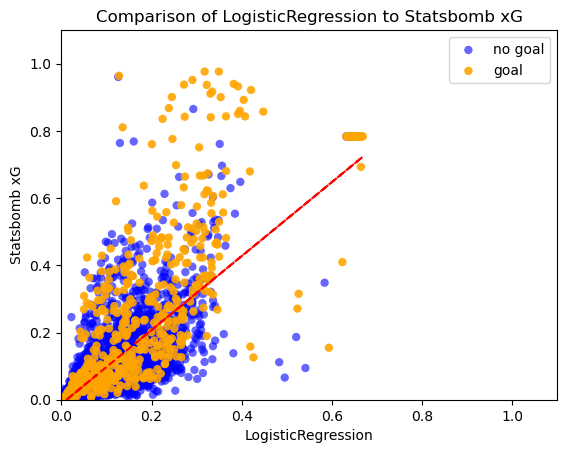

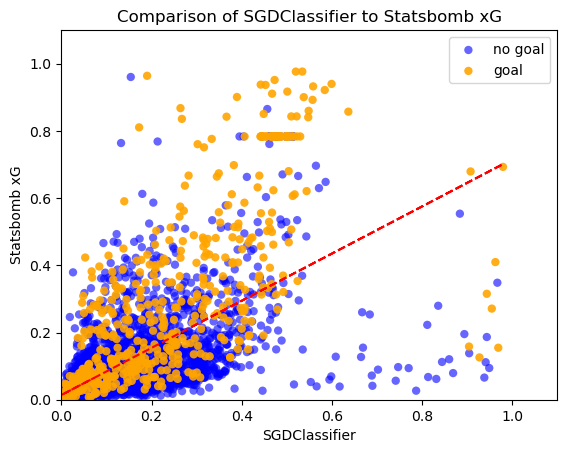

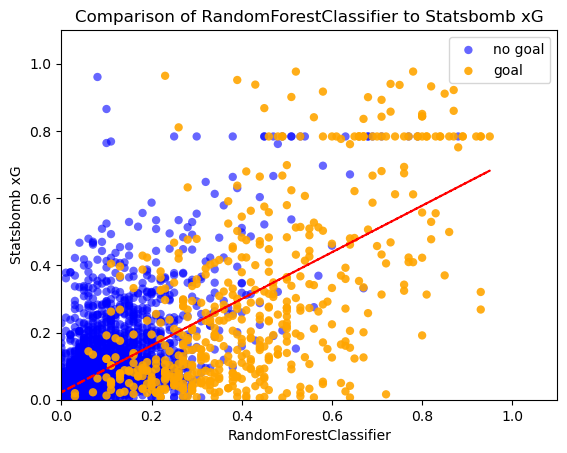

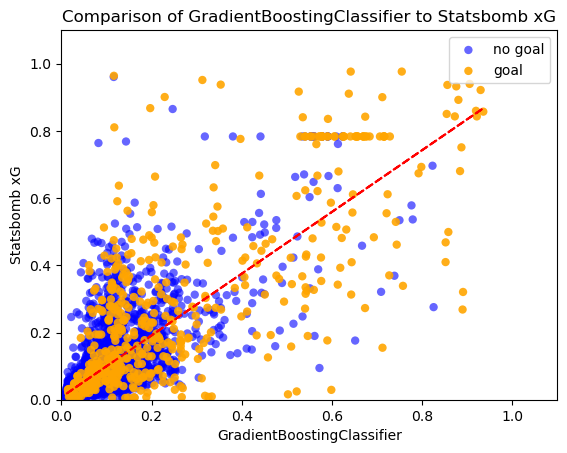

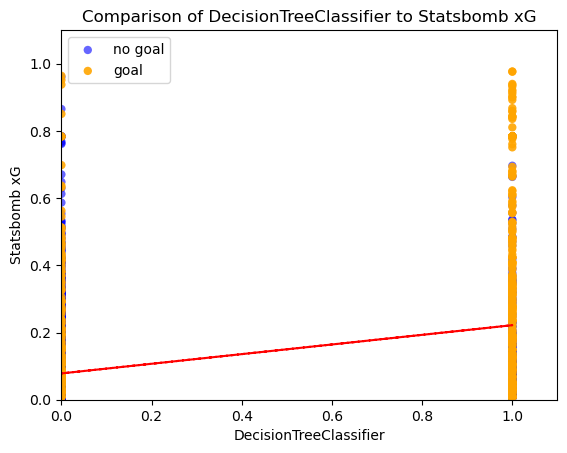

In [48]:
estimator_names = ['LogisticRegression', 'SGDClassifier', 'RandomForestClassifier', 
                  'GradientBoostingClassifier', 'DecisionTreeClassifier']

estimator_list = [LogisticRegression(), SGDClassifier(loss='log_loss'), 
                  RandomForestClassifier(criterion='log_loss'), GradientBoostingClassifier(loss='log_loss'),
                 DecisionTreeClassifier(criterion='log_loss')]
trained_estimator_dict = {}
#model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg']
model_summary = {}
model_summary['shots'] = [len(train_y_df[target_attr])]
model_summary['goals'] = [train_y_df[target_attr].value_counts()[1]]
model_summary['statsbomb_xg'] = [sum(train_cap_x_df['shot_statsbomb_xg'])]
for estimator_name, estimator in zip(estimator_names, estimator_list):
    composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])
    trained_estimator_dict[estimator_name] = composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())
    predictions = trained_estimator_dict[estimator_name].predict_proba(train_cap_x_df)[:,1]
    SBModel = train_cap_x_df['shot_statsbomb_xg']
    shot_outcome = train_y_df[target_attr]
    model_summary[estimator_name] = [sum(predictions)]
    plot_comparison(predictions, estimator_name, SBModel, 'Statsbomb xG', shot_outcome)
#print(pd.DataFrame(model_summary))
pd.DataFrame.from_dict(model_summary)

## Select Best Model and examine Permutation Importance

In [49]:
best_model_name = 'GradientBoostingClassifier'
best_model = trained_estimator_dict[best_model_name]

In [50]:
feature_importances = permutation_importance(
    best_model, train_cap_x_df, train_y_df.values.ravel())

In [51]:
mean_feature_importances = pd.Series(feature_importances.importances_mean, index=train_cap_x_df.columns)
#mean_feature_importances.sort_values(ascending=False)
std_feature_importances = pd.Series(feature_importances.importances_std, index=train_cap_x_df.columns)
#std_feature_importances

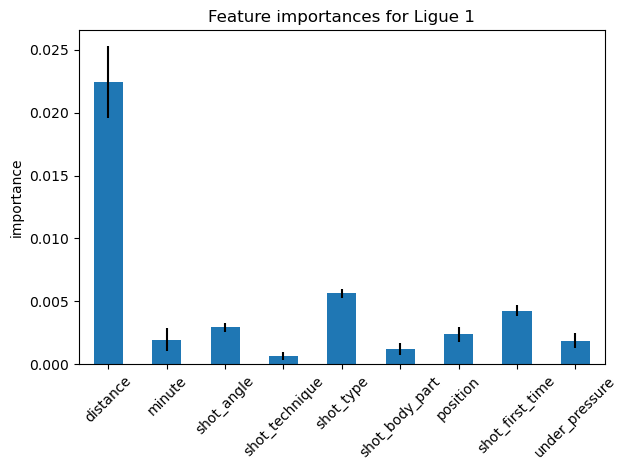

In [52]:
fig, ax = plt.subplots()
#mean_feature_importances[['distance','shot_body_part', 'shot_type', 'shot_angle']].plot.bar(
#    yerr=std_feature_importances[['distance','shot_body_part', 'shot_type', 'shot_angle']], ax=ax)
mean_feature_importances[numerical_attrs+nominal_attrs].plot.bar(
    yerr=std_feature_importances[numerical_attrs+nominal_attrs], ax=ax)
ax.set_title("Feature importances for Ligue 1")
ax.set_ylabel("importance")
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

## Evaluate on Test Set

GradientBoostingClassifier
y=0.87x+0.01
$R^2$= 0.33300773792969107


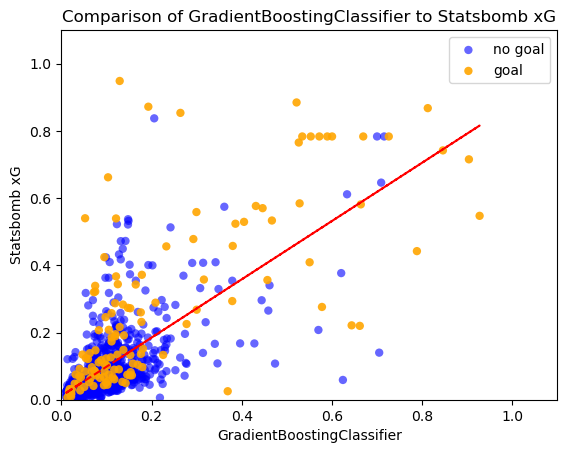

In [53]:
test_predictions = best_model.predict_proba(test_cap_x_df)[:,1]
test_SBModel = test_cap_x_df['shot_statsbomb_xg']
test_shot_outcome = test_y_df[target_attr]
plot_comparison(test_predictions, best_model_name, test_SBModel, 'Statsbomb xG', test_shot_outcome)

## Observe behavior on totality of test set

In [54]:
model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg', 'best_model_xg'])
shots = len(test_y_df[target_attr])
goals = test_y_df[target_attr].value_counts()[1]
statsbomb_xg = sum(test_cap_x_df['shot_statsbomb_xg'])
best_model_xg = sum(test_predictions)
new_row = pd.Series({'shots': shots, 'goals': goals, 'statsbomb_xg': statsbomb_xg, 'best_model_xg': best_model_xg})
model_summary.loc[len(model_summary)]=new_row
model_summary

,shots,goals,statsbomb_xg,best_model_xg
0,1301.0,131.0,120.862447,122.123384


## Examine on Week to Week basis
### Get matches for a particular team

In [55]:
def get_games_for_team(team):
    df = Ligue1[(Ligue1['home_team']==team)|(Ligue1['away_team']==team)]
    df = df.sort_values(by='match_week')
    return df

In [56]:
Lyon_games = get_games_for_team('Lyon')
Lyon_games

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
369,3829422,2015-08-09,21:00:00.000,France - Ligue 1,2015/2016,Lyon,Lorient,0,0,available,...,None,1,Regular Season,Stade de Gerland,Benoît Millot,Hubert Fournier,Sylvain Ripoll,1.1.0,2,2
365,3829426,2015-08-15,20:00:00.000,France - Ligue 1,2015/2016,Guingamp,Lyon,0,1,available,...,None,2,Regular Season,Stade du Roudourou,Antony Gautier,Jocelyn Gourvennec,Hubert Fournier,1.1.0,2,2
358,3829435,2015-08-22,17:00:00.000,France - Ligue 1,2015/2016,Lyon,Rennes,1,2,available,...,None,3,Regular Season,Stade de Gerland,Ruddy Buquet,Hubert Fournier,Philippe Jacques William Montanier,1.1.0,2,2
351,3829444,2015-08-29,17:00:00.000,France - Ligue 1,2015/2016,Caen,Lyon,0,4,available,...,None,4,Regular Season,Stade Michel d''Ornano,Nicolas Rainville,Patrice Garande,Hubert Fournier,1.1.0,2,2
202,3829454,2015-09-12,17:00:00.000,France - Ligue 1,2015/2016,Lyon,Lille,0,0,available,...,None,5,Regular Season,Stade de Gerland,Frank Schneider,Hubert Fournier,Hervé Renard,1.1.0,2,2
329,3829472,2015-09-20,21:00:00.000,France - Ligue 1,2015/2016,Marseille,Lyon,1,1,available,...,None,6,Regular Season,Orange Vélodrome,Ruddy Buquet,José Miguel González Martín del Campo,Hubert Fournier,1.1.0,2,2
325,3829476,2015-09-23,19:00:00.000,France - Ligue 1,2015/2016,Lyon,Bastia,2,0,available,...,None,7,Regular Season,Stade de Gerland,Benoît Bastien,Hubert Fournier,Ghislain Printant,1.1.0,2,2
319,3829484,2015-09-26,20:00:00.000,France - Ligue 1,2015/2016,Bordeaux,Lyon,3,1,available,...,None,8,Regular Season,Stade Matmut Atlantique,Benoît Millot,Willy Sagnol,Hubert Fournier,1.1.0,2,2
193,3829495,2015-10-03,17:30:00.000,France - Ligue 1,2015/2016,Lyon,Stade de Reims,1,0,available,...,None,9,Regular Season,Stade de Gerland,Antony Gautier,Hubert Fournier,Olivier Guégan,1.1.0,2,2
304,3829502,2015-10-16,20:30:00.000,France - Ligue 1,2015/2016,AS Monaco,Lyon,1,1,available,...,None,10,Regular Season,Stade Louis II,Fredy Fautrel,José Leonardo Nunes Alves Sousa Jardim,Hubert Fournier,1.1.0,2,2


## Examine individual matches
We'll look at a match after matchweek 28, since all the matches before matchweek 28 are what are used to train the model.

In [57]:
next_game_week = 35

In [58]:
match = Lyon_games[Lyon_games['match_week']==next_game_week]['match_id'].iloc[0]

In [59]:
def cumulative_sums(array):
    return [sum(array[:i+1]) for i in range(len(array))]

In [60]:
def display_match_results_with_xG(league_df,match, display_shots=False, display_chart=False):
    match_shots_df = pd.DataFrame(columns=relevant_attributes)
    #print(match)
    home_team = league_df[league_df['match_id']==match]['home_team'].values[0]
    home_score = league_df[league_df['match_id']==match]['home_score'].values[0]
    away_team = league_df[league_df['match_id']==match]['away_team'].values[0]
    away_score = league_df[league_df['match_id']==match]['away_score'].values[0]

    match_df = sb.events(match_id=match)
    new_match_df = match_df[relevant_attributes][match_df['type']=='Shot']

    match_shots_df = pd.concat([match_shots_df, new_match_df], ignore_index=True)

    match_shots_df['shot_outcome'] = match_shots_df['shot_outcome'].replace(
        to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
                   'Saved to Post': 0, 'Saved Off Target': 0})

    match_shots_df['distance'] = match_shots_df.apply(lambda row: np.sqrt(np.abs(
        row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
    match_shots_df['shot_angle'] = match_shots_df.apply(
        lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
    match_shots_df = match_shots_df.sort_values(by='minute')
    
    cap_x_df = pd.concat([match_shots_df.iloc[:,:-4], 
                              match_shots_df.iloc[:,-3:]], axis=1)
    
    predictions = best_model.predict_proba(cap_x_df)[:,1]
    predictions_df = pd.DataFrame({'best_model': predictions})
    match_shots_df['best_model']= predictions_df
    
    home_shots_df = match_shots_df[match_shots_df['team']==home_team]
    away_shots_df = match_shots_df[match_shots_df['team']==away_team]

    home_cap_x_df = pd.concat([home_shots_df.iloc[:,:-5], 
                                home_shots_df.iloc[:,-4:]], axis=1)
    away_cap_x_df = pd.concat([away_shots_df.iloc[:,:-5], 
                                away_shots_df.iloc[:,-4:]], axis=1)
    
    home_predictions = home_cap_x_df['best_model']
    away_predictions = away_cap_x_df['best_model']
    
    home_total_best_model_xG = sum(home_predictions)
    away_total_best_model_xG = sum(away_predictions)
    home_statsbomb_xG = sum(home_cap_x_df['shot_statsbomb_xg'])
    away_statsbomb_xG = sum(away_cap_x_df['shot_statsbomb_xg'])
    if display_shots == True:
        display(match_shots_df)
    print("Proposed model")
    print("%s (%.2f) %.0f-%.0f (%.2f) %s" % (home_team, home_total_best_model_xG, home_score, away_score, away_total_best_model_xG, away_team))
    print("statsbomb xG")
    print("%s (%.2f) %.0f-%.0f (%.2f) %s" % (home_team, home_statsbomb_xG, home_score, away_score, away_statsbomb_xG, away_team))
    if display_chart==True:
        home_team_xg = [0]
        away_team_xg = [0]
        home_min = [0]
        away_min = [0]
        for x in range(len(match_shots_df)):
            if match_shots_df['team'][x] == home_team:
                home_team_xg.append(match_shots_df['best_model'][x])
                home_min.append(match_shots_df['minute'][x])
            if match_shots_df['team'][x] == away_team:
                away_team_xg.append(match_shots_df['best_model'][x])
                away_min.append(match_shots_df['minute'][x])
        home_cumulative_xg = cumulative_sums(home_team_xg)
        away_cumulative_xg = cumulative_sums(away_team_xg)

        fig, ax = plt.subplots(figsize= (10,5))
        plt.xticks([0,15,30,45,60,75,90])
        plt.xlabel("minute")
        plt.ylabel("model xG")
        plt.title("Cumulative xG by minute")
        home, = ax.step(x=home_min, y=home_cumulative_xg, label=home_team)
        away, = ax.step(x=away_min, y=away_cumulative_xg, label=away_team)
        ax.legend(handles=[home,away])
    #return match_shots_df

Proposed model
Toulouse (1.70) 2-3 (1.27) Lyon
statsbomb xG
Toulouse (1.78) 2-3 (1.74) Lyon


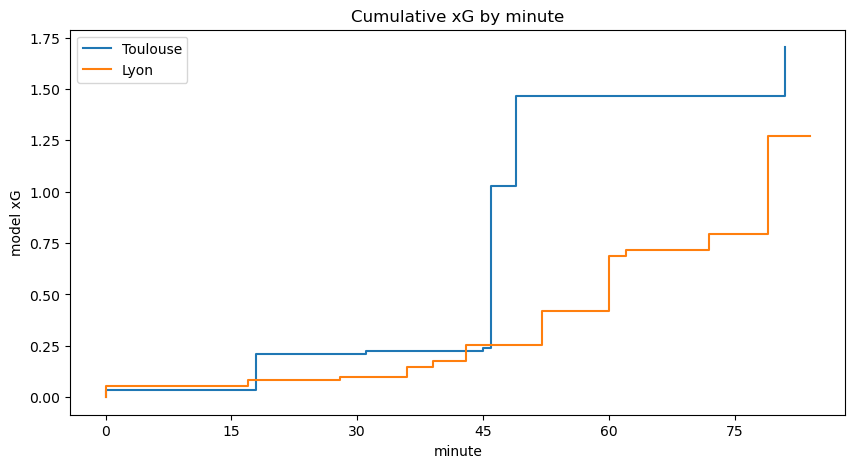

In [61]:
display_match_results_with_xG(Lyon_games,match, display_shots=False, display_chart=True)